In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import requests
import json
import folium
import pgeocode
import datetime

In [3]:
def read_covid_data():
    global latitude, longtitude, newly_confirmed_10, covid_data_frame
    longtitude = []
    latitude = []
    location_code = []

    base_url = "https://api.covid19api.com/summary"
    base_page = requests.get(base_url)

    covid_data = BeautifulSoup(base_page.content, 'html.parser')
    covid_json_data = json.loads(str(covid_data))

    covid_data_frame = pd.DataFrame.from_dict(covid_json_data['Countries'])
    covid_data_frame.set_index(keys = ['Country'], inplace = True, drop = False)
    newly_confirmed_10 = covid_data_frame.nlargest(10, "NewConfirmed")
    
    for country in newly_confirmed_10.CountryCode:
        geolocator = geolocator = Nominatim(user_agent = "Covid_world_wide_data")
        location = geolocator.geocode(country)
        latitude.append(location.latitude)
        longtitude.append(location.longitude)

    print(covid_data_frame.columns)
        
read_covid_data()

Index(['Country', 'CountryCode', 'Slug', 'NewConfirmed', 'TotalConfirmed',
       'NewDeaths', 'TotalDeaths', 'NewRecovered', 'TotalRecovered', 'Date',
       'Premium'],
      dtype='object')


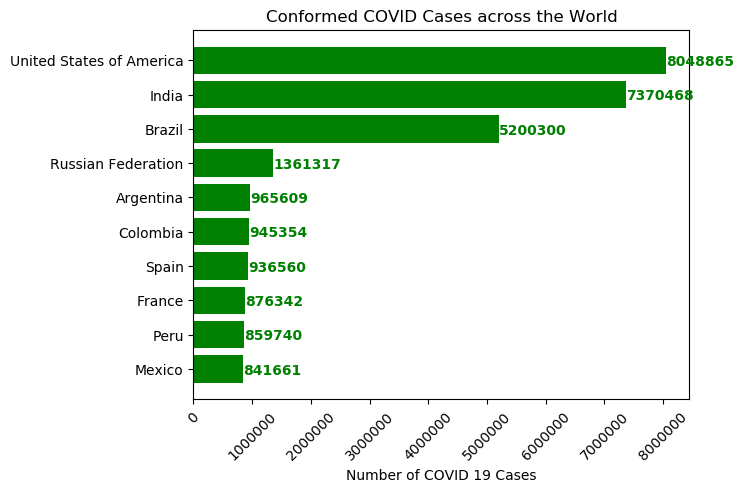

In [4]:
def total_confirmed(total_confirmed_covid_cases):
    x_axis = list(total_confirmed_covid_cases['Country'])
    y_axis = list(total_confirmed_covid_cases['TotalConfirmed'])
    plt.rcdefaults()
    fix, ax = plt.subplots()

    ax.barh(x_axis,y_axis, align='center', color = 'green', data = y_axis)
    plt.xticks(rotation=45)
    ax.invert_yaxis()
    ax.set_xlabel('Number of COVID 19 Cases')
    ax.set_title('Conformed COVID Cases across the World')
    for i, v in enumerate(y_axis):
        ax.text(v + 3, i + .15, str(v), color='green', fontweight='bold')
    plt.show()
total_confirmed(covid_data_frame.nlargest(10,'TotalConfirmed'))

In [5]:
def newly_confirmed():
    global m
    newly_confirmed_covid = pd.DataFrame({'latitude' : latitude,
                                        'longtitude' : longtitude,
                                         'country' : (newly_confirmed_10.Country).to_list(),
                                         'Newly_confirmed' : list(newly_confirmed_10.NewConfirmed)})
    m = folium.Map(location = [90, -90],
                    zoom_start = 2)
    
    for i in range(0,10):
       folium.Circle(
          location=[float(newly_confirmed_covid.iloc[i]['latitude']), float(newly_confirmed_covid.iloc[i]['longtitude'])],
          popup=str(newly_confirmed_covid.iloc[i]['country'])+" newly confirmed "+ str(newly_confirmed_covid.iloc[i]['Newly_confirmed']*10),
          radius=int(newly_confirmed_covid.iloc[i]['Newly_confirmed']*10),
          color='crimson',
          fill=True,
          fill_color='crimson'
       ).add_to(m)
    print(newly_confirmed_covid)
    
newly_confirmed()

    latitude  longtitude                   country  Newly_confirmed
0  39.783730 -100.445882  United States of America            69156
1 -10.333333  -53.200000                    Brazil            30914
2  46.603354    1.888334                    France            25345
3 -34.996496  -64.967282                 Argentina            16546
4  54.702354   -3.276575            United Kingdom            15657
5  39.326234   -4.838065                     Spain            15186
6  64.686314   97.745306        Russian Federation            14937
7  49.816700   15.474954            Czech Republic            11102
8  50.640281    4.666715                   Belgium            10192
9  42.638426   12.674297                     Italy            10009


In [6]:
m

                Cases Country Month_Year
Month Year                              
1     2020          2   India     1-2020
2     2020         84   India     2-2020
3     2020      10252   India     3-2020
4     2020     447607   India     4-2020
5     2020    3088494   India     5-2020
6     2020   10951713   India     6-2020
7     2020   32829678   India     7-2020
8     2020   82734792   India     8-2020
9     2020  151735176   India     9-2020
10    2020  110841888   India    10-2020


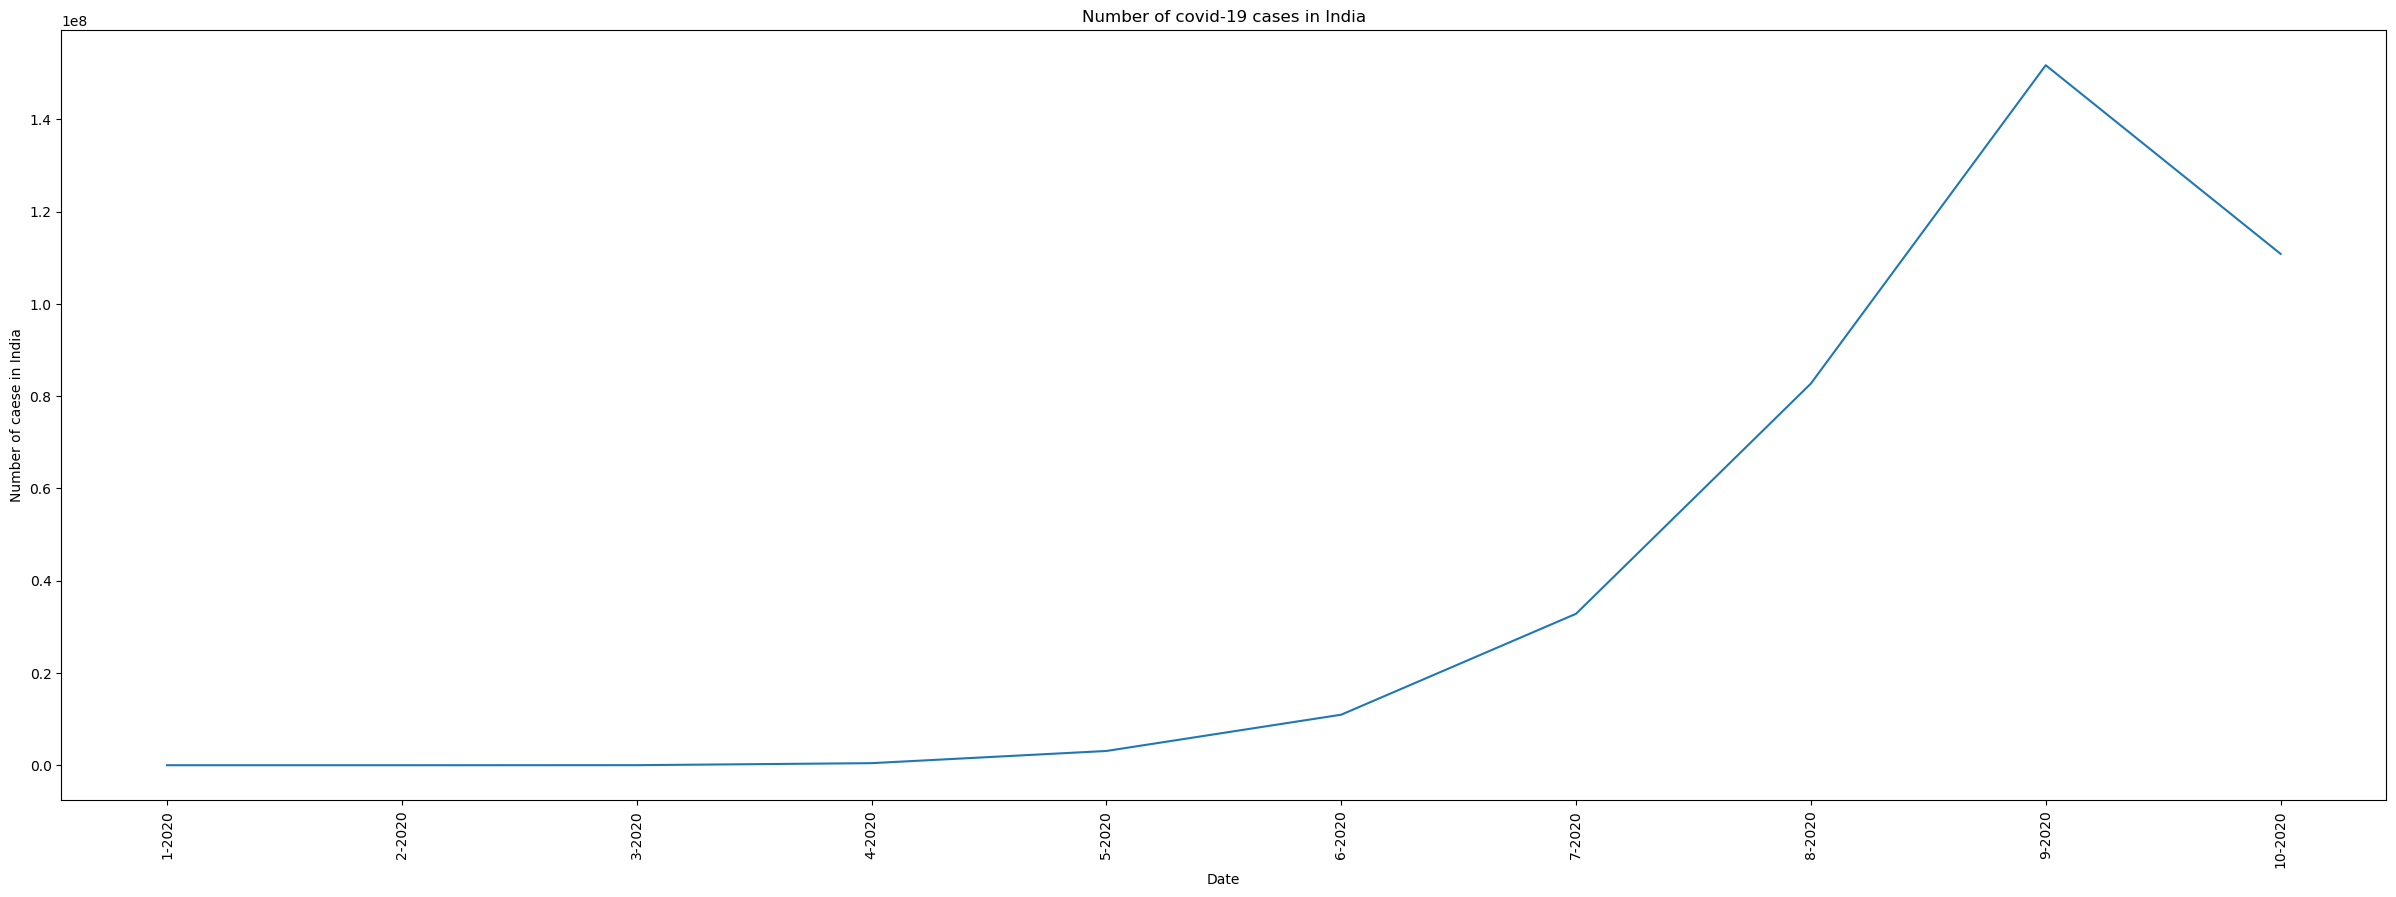

In [7]:
def india_covid_cases():
    base_url = "https://api.covid19api.com/total/dayone/country/india/status/confirmed"
    month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    base_india_covid_data = requests.get(base_url)
    base_india_covid_data = BeautifulSoup(base_india_covid_data.content,'html.parser')
    india_covid_data_json = json.loads(str(base_india_covid_data))
    india_covid_dataframe = pd.DataFrame.from_dict(india_covid_data_json)
    
    #print(india_covid_dataframe.head())
    
    india_covid_dataframe.Date = pd.to_datetime(india_covid_dataframe.Date, dayfirst = True)
    
    india_covid_dataframe['Year'] = pd.DatetimeIndex(india_covid_dataframe['Date']).year
    india_covid_dataframe['Month'] = pd.DatetimeIndex(india_covid_dataframe['Date']).month
    month_wise_covid_data = india_covid_dataframe.groupby(by = ['Month', 'Year']).sum()
    month_wise_covid_data["Country"] = india_covid_dataframe.Country[0]
    
    Month_Year = []
    for month, year in month_wise_covid_data.index:
        Month_Year.append(str(month)+"-"+str(year))
    
    month_wise_covid_data['Month_Year'] = Month_Year
    print(month_wise_covid_data)
    plt.figure(figsize = [30,10])
    plt.subplot(1,1,1)
    plt.plot(month_wise_covid_data['Month_Year'], month_wise_covid_data['Cases'])
    plt.ylabel("Number of caese in India")
    plt.xlabel("Date")
    plt.xticks(rotation = 'vertical')
    plt.title("Number of covid-19 cases in India")

india_covid_cases()